In [1]:
import os
import zipfile
import numpy as np
import cv2 as cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# Path to the zip file
zip_path = '/content/drive/MyDrive/graduation model/Vegetable Images.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Path to the dataset folder
dataset_folder = '/content/dataset/Vegetable Images'

In [4]:
image_size = (128, 128)

In [5]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv.imread(image_path)
    # Resize image to target size
    image = cv.resize(image, target_size)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image

# Initialize lists to store images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

In [6]:
# Loop through train and test folders
for split in ['train', 'test']:
    split_path = os.path.join(dataset_folder, split)
    vegetables_type = os.listdir(split_path)
    for vtype in vegetables_type:
        vegetable_path = os.path.join(split_path, vtype)
        image_files = os.listdir(vegetable_path)
        for image_file in image_files:
            image_path = os.path.join(vegetable_path, image_file)
            # Preprocess image
            image = preprocess_image(image_path)
            if split == 'train':
                train_images.append(image)
                train_labels.append(vtype)
            else:
                test_images.append(image)
                test_labels.append(vtype)


In [7]:
print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))



15000
15000
3000
3000


In [8]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)


In [9]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
train_labels_encoded = encoder.fit_transform([[label] for label in train_labels])
test_labels_encoded = encoder.transform([[label] for label in test_labels])

# Convert back to list if needed
train_labels_encoded_list = train_labels_encoded.tolist()
test_labels_encoded_list = test_labels_encoded.tolist()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
train_labels_encoded = np.array(train_labels_encoded)
test_labels_encoded = np.array(test_labels_encoded)

num_classes = len(train_labels_encoded)

model_path = '/content/model.keras'
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    verbose=32,
    save_best_only=True
)
callbacks = [checkpoint]

In [12]:
# Input shape and layer.
input_shape = (128, 128, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization(momentum=0.95, epsilon=0.05,
                             beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
                             gamma_initializer=Constant(value=0.9)))
model.add(Dense(15, activation='softmax'))



initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
import tensorflow as tf

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Prints model summary
model.summary()

# Train the model using train_images and train_labels, and validate using test_images and test_labels
history = model.fit(train_images, train_labels_encoded, epochs=20, validation_data=(test_images, test_labels_encoded), callbacks=callbacks)

# Load best model weights from checkpoint and save results
model.load_weights(model_path)
res = model.evaluate(test_images, batch_size=32)
# Prints results
print("Results")
print(res)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 activation_2 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 65536)            

94/94 [==============================] - 2s 24ms/step


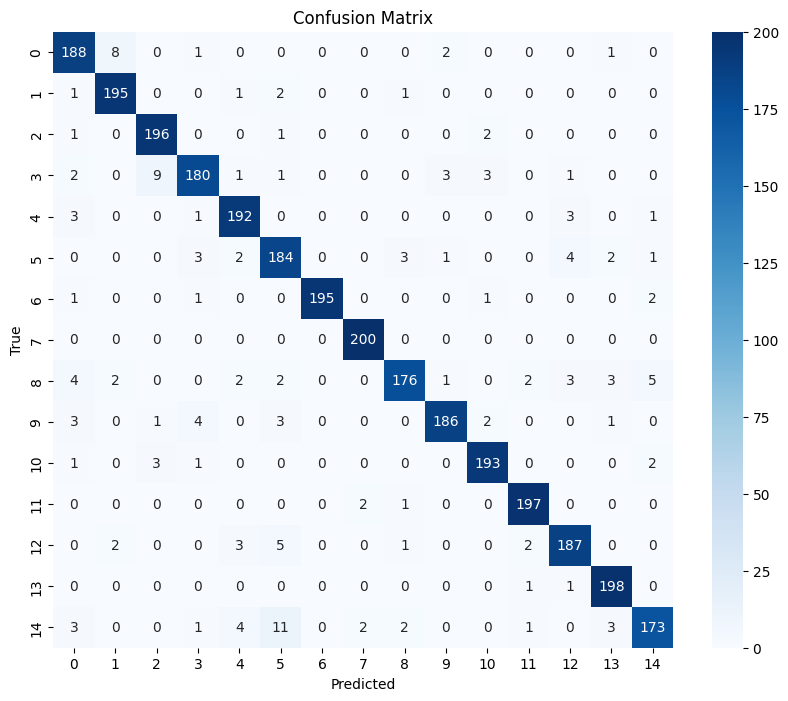

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       200
           1       0.94      0.97      0.96       200
           2       0.94      0.98      0.96       200
           3       0.94      0.90      0.92       200
           4       0.94      0.96      0.95       200
           5       0.88      0.92      0.90       200
           6       1.00      0.97      0.99       200
           7       0.98      1.00      0.99       200
           8       0.96      0.88      0.92       200
           9       0.96      0.93      0.95       200
          10       0.96      0.96      0.96       200
          11       0.97      0.98      0.98       200
          12       0.94      0.94      0.94       200
          13       0.95      0.99      0.97       200
          14       0.94      0.86      0.90       200

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95   

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Assuming test_labels_encoded is one-hot encoded, convert it to class labels
y_true = np.argmax(test_labels_encoded, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))